
=== Running Scenario 1 ===
Saved: result/kl_points_from_plot_1.csv  (57 rows)

=== Running Scenario 2 ===
Saved: result/kl_points_from_plot_2.csv  (57 rows)

=== Running Scenario 3 ===
Saved: result/kl_points_from_plot_3.csv  (57 rows)

=== Running Scenario 4 ===
Saved: result/kl_points_from_plot_4.csv  (57 rows)

=== Running Scenario 5 ===
Saved: result/kl_points_from_plot_5.csv  (57 rows)

=== Running Scenario 6 ===
Saved: result/kl_points_from_plot_6.csv  (57 rows)

=== Running Scenario 7 ===
Saved: result/kl_points_from_plot_7.csv  (57 rows)

=== Running Scenario 8 ===
Saved: result/kl_points_from_plot_8.csv  (57 rows)

Saved combined figure: result/scenarios_1to8_by_algorithm.png


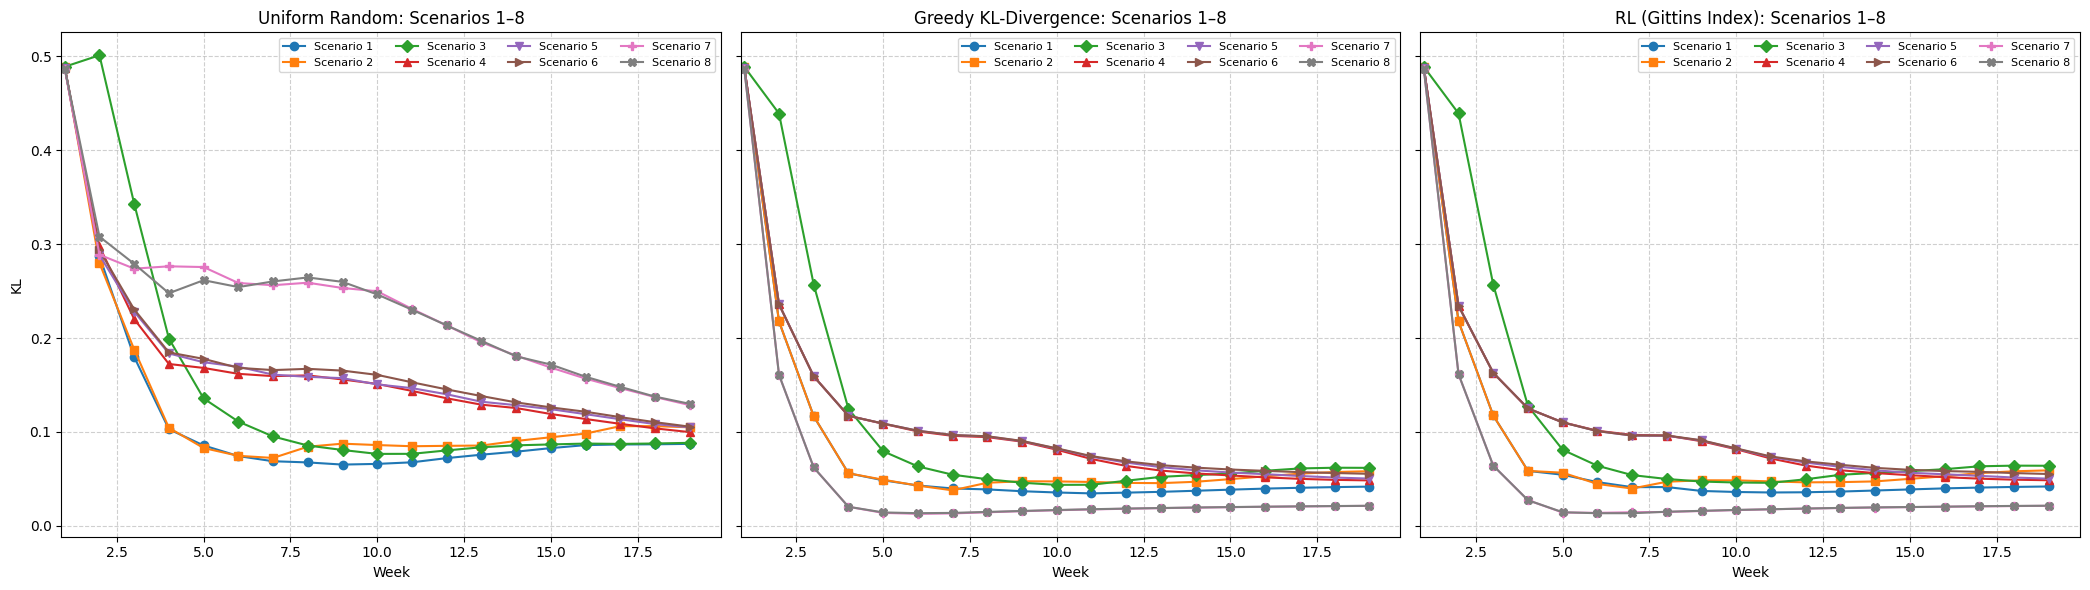

Saved: result/scenarios_1to8_vs_cum_infections.png


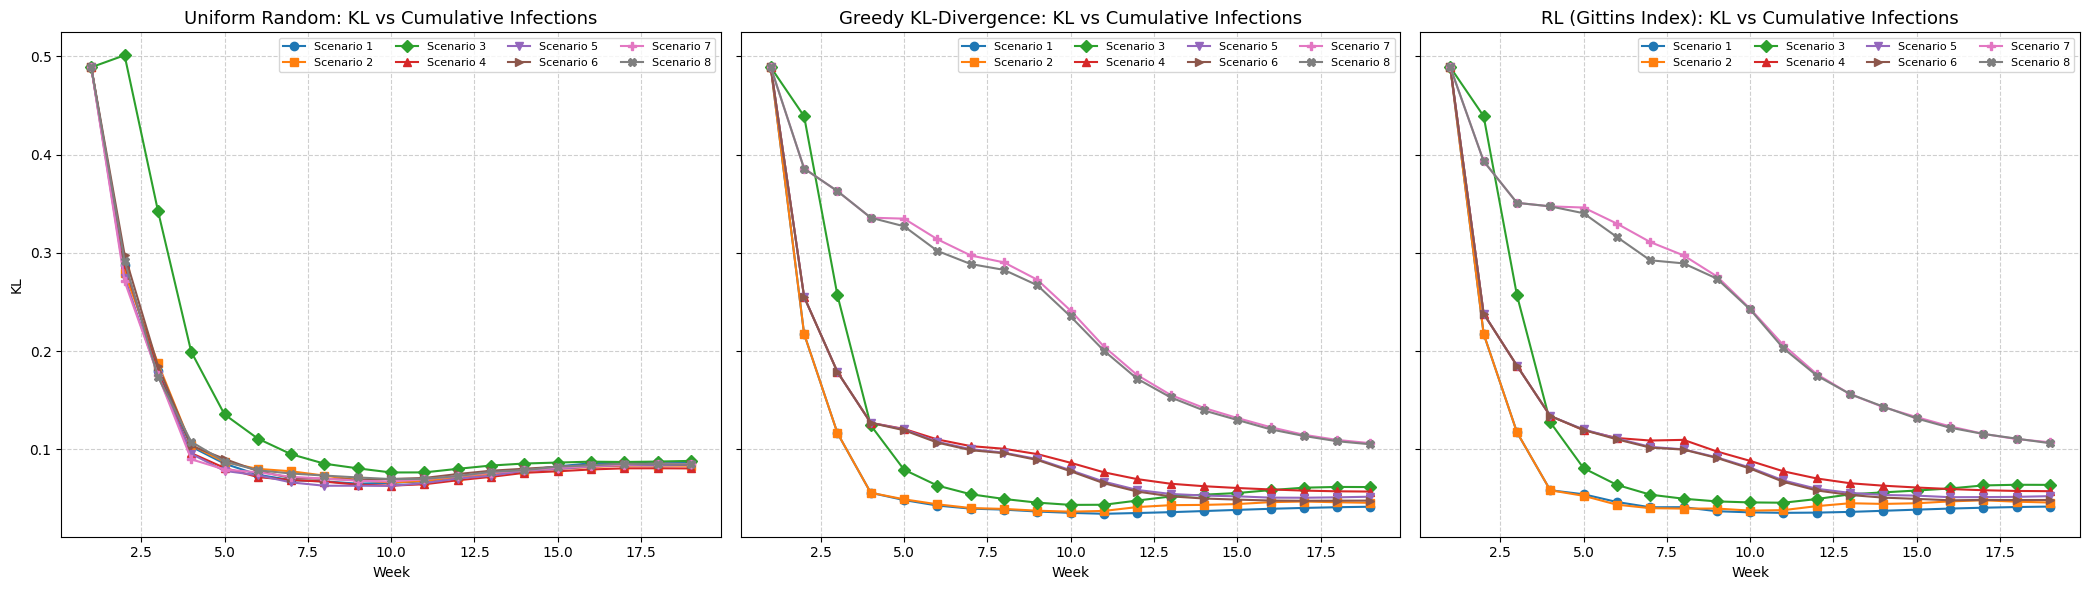

Saved: result/scenarios_1to8_vs_roll4_infections.png


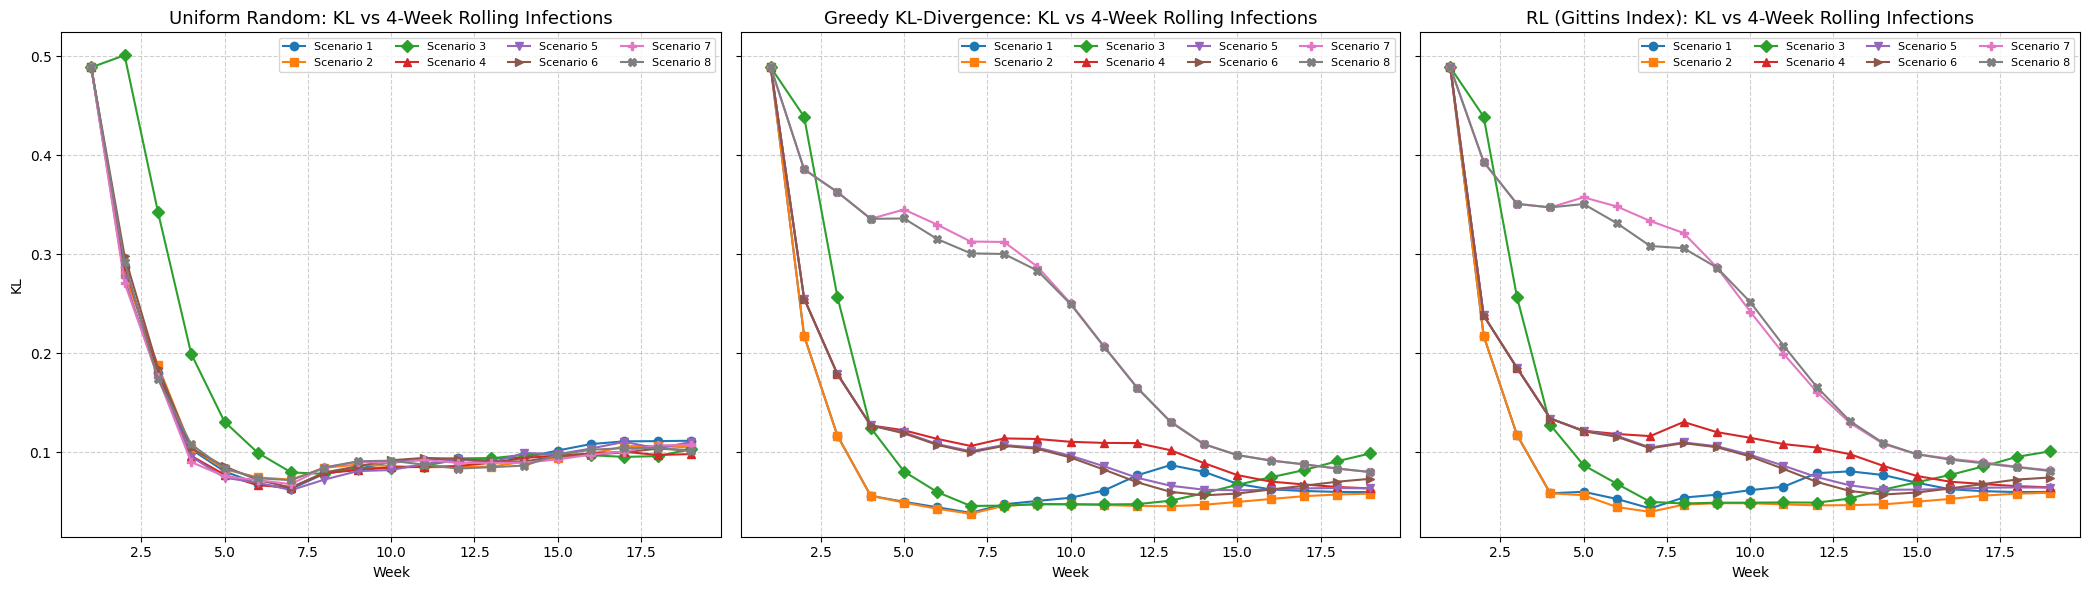

In [1]:
# Run scenarios 1–8 in one go and produce 3 plots (one per algorithm) with 8 lines each.

import pandas as pd
import numpy as np
from scipy.stats import entropy
from collections import defaultdict, deque
from datetime import timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import time
import re

# ======================================================
# Configuration (edit these only)
# ======================================================
LINE_LIST_FILE   = "simulated_test_positive_linelist.csv"
POPULATION_FILE  = "va_persontrait_epihiper.txt"
DATE_FIELD       = "date"
START_DATE       = pd.to_datetime("2021-05-31")
MINIMUM_POOL_SIZE= 50
GROUP_FEATURES   = ["age_group", "smh_race"]
all_weekly_hist = {}   # scenario_id -> {algorithm: [Series per week]}

# Scenario table:
# - name: legend / bookkeeping
# - target_mode: "linelist_dynamic" or "population_static"
# - decision_window_weeks: None (cumulative) or int (rolling prior used for sampler decisions)
# - eval_metric: what to plot
#       "kl_vs_linelist_cum"
#       "kl_vs_linelist_rolling"  (uses eval_window_weeks)
#       "kl_vs_population_cum"
#       "mean_kl_cum"   (0.5*(kl_vs_linelist_cum + kl_vs_population_cum))
# - eval_window_weeks: only used when eval_metric == "kl_vs_linelist_rolling"
# - batch_frac: dynamic batch = min(batch_frac * pool_size, batch_cap)
# - batch_cap: per-week cap
# - min_per_group: weekly minimum coverage
# -----------------------------
# Scenario definitions (Table 3)
# -----------------------------
ROLL_W = 4
BATCH_FRAC_DEFAULT = 0.25
BATCH_CAP_DEFAULT  = 1000
MIN_PER_GROUP_DEFAULT = 10
BLEND_ALPHA = 0.5   # weight on LineList when blending with Population

SCENARIOS = [
    # 1) CS–C(LL): cumulative sampling → cumulative LineList target
    {
        "id": 1, "name": "Scenario 1",
        "target_mode": "linelist_dynamic",
        "target_linelist_mode": "cumulative",
        "target_linelist_window": None,
        "decision_window_weeks": None,             # cumulative sampling
        "eval_metric": "kl_vs_linelist_cum",       # plot vs cumulative LL
        "eval_window_weeks": None,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 2) RS–R(LL): rolling sampling → rolling LineList target
    {
        "id": 2, "name": "Scenario 2",
        "target_mode": "linelist_dynamic",
        "target_linelist_mode": "rolling",
        "target_linelist_window": ROLL_W,
        "decision_window_weeks": ROLL_W,           # rolling sampling
        "eval_metric": "kl_vs_linelist_rolling",   # plot vs rolling LL
        "eval_window_weeks": ROLL_W,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 3) RS–C(LL): rolling sampling → cumulative LineList target
    {
        "id": 3, "name": "Scenario 3",
        "target_mode": "linelist_dynamic",
        "target_linelist_mode": "cumulative",
        "target_linelist_window": None,
        "decision_window_weeks": ROLL_W,           # rolling sampling
        "eval_metric": "kl_vs_linelist_cum",       # plot vs cumulative LL
        "eval_window_weeks": None,
        "batch_frac": 0.18, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 4) CS–C(LL,P): cumulative sampling → cumulative blended (LL + P)
    {
        "id": 4, "name": "Scenario 4",
        "target_type": "blend", "blend_alpha": BLEND_ALPHA,
        "target_linelist_mode": "cumulative",
        "target_linelist_window": None,
        "decision_window_weeks": None,             # cumulative sampling
        "eval_metric": "mean_kl_cum",              # 0.5 * KL( … vs LL_cum ) + 0.5 * KL( … vs P )
        "eval_window_weeks": None,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 5) RS–R(LL,P): rolling sampling → rolling blended (LL + P)
    {
        "id": 5, "name": "Scenario 5",
        "target_type": "blend", "blend_alpha": BLEND_ALPHA,
        "target_linelist_mode": "rolling",
        "target_linelist_window": ROLL_W,
        "decision_window_weeks": ROLL_W,           # rolling sampling
        "eval_metric": "mean_kl_cum",
        "eval_window_weeks": None,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 6) RS–C(LL,P): rolling sampling → cumulative blended (LL + P)
    {
        "id": 6, "name": "Scenario 6",
        "target_type": "blend", "blend_alpha": BLEND_ALPHA,
        "target_linelist_mode": "cumulative",
        "target_linelist_window": None,
        "decision_window_weeks": ROLL_W,           # rolling sampling
        "eval_metric": "mean_kl_cum",
        "eval_window_weeks": None,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 7) CS–P: cumulative sampling → Population target
    {
        "id": 7, "name": "Scenario 7",
        "target_mode": "population_static",
        "decision_window_weeks": None,             # cumulative sampling
        "eval_metric": "kl_vs_population_cum",
        "eval_window_weeks": None,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },

    # 8) RS–P: rolling sampling → Population target
    {
        "id": 8, "name": "Scenario 8",
        "target_mode": "population_static",
        "decision_window_weeks": ROLL_W,           # rolling sampling
        "eval_metric": "kl_vs_population_cum",
        "eval_window_weeks": None,
        "batch_frac": BATCH_FRAC_DEFAULT, "batch_cap": BATCH_CAP_DEFAULT, "min_per_group": MIN_PER_GROUP_DEFAULT,
    },
]


# ======================================================
# Utils
# ======================================================
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df["group"] = df[features].agg("_".join, axis=1)
    return df

def kl_dist(p: pd.Series, q: pd.Series) -> float:
    # p and q are probabilities indexed by group
    idx = p.index.union(q.index)
    p = p.reindex(idx, fill_value=1e-9)
    q = q.reindex(idx, fill_value=1e-9)
    return float(entropy(p, q))

def cumulative_kl_vs_linelist(weekly_sample_hist, weekly_linelist_hist):
    cum_s, cum_l = pd.Series(dtype=float), pd.Series(dtype=float)
    out = []
    n = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(n):
        cum_s = cum_s.add(weekly_sample_hist[i], fill_value=0)
        cum_l = cum_l.add(weekly_linelist_hist[i], fill_value=0)
        out.append(kl_dist(cum_s / cum_s.sum(), cum_l / cum_l.sum()))
    return out

def cumulative_kl_vs_population(weekly_sample_hist, pop_dist):
    cum_s = pd.Series(dtype=float)
    out = []
    for wk in weekly_sample_hist:
        cum_s = cum_s.add(wk, fill_value=0)
        out.append(kl_dist(cum_s / cum_s.sum(), pop_dist))
    return out

def rolling_kl_vs_linelist(weekly_sample_hist, weekly_linelist_hist, window_weeks=4):
    out = []
    n = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(n):
        s = pd.Series(dtype=float)
        l = pd.Series(dtype=float)
        start = max(0, i - window_weeks + 1)
        for j in range(start, i + 1):
            s = s.add(weekly_sample_hist[j],   fill_value=0)
            l = l.add(weekly_linelist_hist[j], fill_value=0)
        out.append(kl_dist(s / s.sum(), l / l.sum()))
    return out


def _linelist_dist_at_week(weekly_linelist_history, week_idx, mode="cumulative", window_weeks=4):
    """Return a normalized linelist distribution at week_idx for the given mode."""
    counts = pd.Series(dtype=float)
    if mode == "cumulative":
        rng = range(0, week_idx + 1)
    elif mode == "rolling":
        start = max(0, week_idx - window_weeks + 1)
        rng = range(start, week_idx + 1)
    else:
        raise ValueError(f"Unknown linelist mode: {mode}")
    for j in rng:
        counts = counts.add(weekly_linelist_history[j], fill_value=0)
    counts = counts[counts > 0]
    return counts / counts.sum() if counts.sum() > 0 else counts

def _blended_target(linelist_dist, pop_dist, alpha=0.5):
    """alpha * linelist + (1-alpha) * population, normalized."""
    tgt = linelist_dist.mul(alpha).add(pop_dist.mul(1 - alpha), fill_value=0.0)
    return tgt / tgt.sum()

# ======================================================
# Samplers (same logic as your versions, but allowing a rolling prior)
# ======================================================
def reward_function(group, all_samples, target_dist):
    current = pd.Series(all_samples).value_counts(normalize=True)
    curr = current.get(group, 1e-6)
    targ = target_dist.get(group, 1e-6)
    return -np.log(curr / targ)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group,
                                      pulls, rewards, prior_groups):
    sampled_groups = []
    df = line_df.copy()
    group_counts = df["group"].value_counts()
    avail = group_counts.index.tolist()

    # min coverage first
    initial_dfs = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            cnt = min(min_per_group, group_counts[g])
            samp = df[df["group"] == g].sample(cnt)
            initial_dfs.append(samp)
            sampled_groups.extend([g] * cnt)
            group_counts[g] -= cnt

    remaining = batch_size - len(sampled_groups)
    if remaining <= 0:
        return pd.concat(initial_dfs, ignore_index=True) if initial_dfs else pd.DataFrame()

    # credit those initial picks against current rolling prior
    for g in sampled_groups:
        pulls[g]   = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, prior_groups + sampled_groups, target_dist)

    # continue
    for _ in range(remaining):
        best_g, best_idx = None, -np.inf
        current_rolling = pd.Series(prior_groups + sampled_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in avail:
            if group_counts.get(g, 0) > 0:
                mean_r = rewards.get(g, 0.0) / max(1, pulls.get(g, 1))
                explore = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr = current_rolling.get(g, 1e-6)
                targ = target_dist.get(g, 1e-6)
                under = np.log(1 + (targ / (curr + 1e-6)))
                score = mean_r + explore + under
                if score > best_idx:
                    best_idx, best_g = score, g
        if best_g:
            sampled_groups.append(best_g)
            pulls[best_g]   = pulls.get(best_g, 0) + 1
            rewards[best_g] = rewards.get(best_g, 0.0) + reward_function(best_g, prior_groups + sampled_groups, target_dist)
            group_counts[best_g] -= 1

    # materialize rows
    counts = pd.Series(sampled_groups).value_counts()
    final = [d for d in initial_dfs]
    for g, cnt in counts.items():
        init_cnt = sum(len(d[d["group"] == g]) for d in initial_dfs) if initial_dfs else 0
        need = cnt - init_cnt
        if need > 0:
            pool = df[df["group"] == g]
            final.append(pool.sample(min(need, len(pool))))
    return pd.concat(final, ignore_index=True) if final else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, prior_groups):
    picked = []
    df = line_df.copy()
    group_counts = df["group"].value_counts().to_dict()
    target_groups = target_dist.index.tolist()

    # min coverage
    parts = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            cnt = min(min_per_group, group_counts[g])
            smp = df[df["group"] == g].sample(cnt)
            parts.append(smp)
            picked.extend([g] * cnt)
            group_counts[g] -= cnt

    remaining = batch_size - len(picked)
    if remaining <= 0:
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # greedy add to minimize KL(rolling -> target)
    for _ in range(remaining):
        best_g, best_kl = None, float("inf")
        cand = [g for g, c in group_counts.items() if c > 0]
        for g in cand:
            trial = prior_groups + picked + [g]
            p = pd.Series(trial).value_counts(normalize=True).reindex(target_dist.index, fill_value=0.0)
            q = target_dist.reindex(p.index)
            kl = float(entropy(p + 1e-9, q + 1e-9))
            if kl < best_kl:
                best_kl, best_g = kl, g
        if best_g:
            picked.append(best_g)
            group_counts[best_g] -= 1
        else:
            break

    # materialize rows
    counts = pd.Series(picked).value_counts()
    final = []
    for g, cnt in counts.items():
        pool = df[df["group"] == g]
        final.append(pool.sample(min(cnt, len(pool))))
    return pd.concat(final, ignore_index=True) if final else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    df = line_df.copy()
    group_counts = df["group"].value_counts()
    target_groups = target_dist.index.tolist()
    parts = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            cnt = min(min_per_group, group_counts[g])
            parts.append(df[df["group"] == g].sample(cnt))
    initial = pd.concat(parts) if parts else pd.DataFrame()
    df = df.drop(initial.index) if not initial.empty else df
    remaining = batch_size - len(initial)
    if remaining <= 0:
        return initial
    take = min(remaining, len(df))
    rand = df.sample(take, replace=False) if take > 0 else pd.DataFrame()
    return pd.concat([initial, rand], ignore_index=True)

# ======================================================
# Data loading / preprocessing
# ======================================================
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df  = pd.read_csv(POPULATION_FILE, skiprows=1)

pop_df["age_group"] = pop_df["age_group"].map({
    "p":"Preschool (0-4)", "s":"Student (5-17)", "a":"Adult (18-49)",
    "o":"Older adult (50-64)", "g":"Senior (65+)"
})
pop_df = pop_df.rename(columns={"gender":"sex"})
pop_df["sex"]      = pop_df["sex"].astype(str).map({"1":"male","2":"female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W":"White","B":"Black","L":"Latino","A":"Asian","O":"Other"})

line_df = make_group(line_df, GROUP_FEATURES)
pop_df  = make_group(pop_df,  GROUP_FEATURES)

POP_DIST_STATIC = pop_df["group"].value_counts(normalize=True).sort_index()

# Build weekly linelist history once for evaluation
weekly_linelist_history = []
cur = START_DATE
while True:
    prev_mon = cur - timedelta(days=7)
    prev_sun = cur - timedelta(days=1)
    wk = line_df[(line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)]
    if len(wk) < MINIMUM_POOL_SIZE:
        break
    weekly_linelist_history.append(wk["group"].value_counts())
    cur += timedelta(weeks=1)

# ======================================================
# Scenario runner
# ======================================================
ALGORITHMS = {
    "Uniform Random": lambda df, td, bs, mpg, st: uniform_sampler_with_min_coverage(df, td, bs, mpg),
    "Greedy KL-Divergence": lambda df, td, bs, mpg, st: greedy_kl_sampler(df, td, bs, mpg, st),
    "RL (Gittins Index)":   lambda df, td, bs, mpg, st: gittins_sampler_with_min_coverage(df, td, bs, mpg, pulls, rewards, st),
}

def run_one_scenario(scfg):
    """
    Run one scenario and return:
      weekly_hist: {algorithm -> [pd.Series]}  # counts by group per sampled week
      per_algo_eval: {algorithm -> [float]}    # KL series for the requested eval metric
    """

    import pandas as pd
    from scipy.stats import entropy
    from collections import deque
    from datetime import timedelta

    # ---------- local helpers ----------
    def _kl(p, q):
        idx = p.index.union(q.index)
        p = p.reindex(idx, fill_value=1e-9)
        q = q.reindex(idx, fill_value=1e-9)
        return float(entropy(p, q))

    def _linelist_dist_at_week(week_idx, mode="cumulative", window_weeks=4):
        """Normalized linelist distribution at week_idx using cumulative or rolling window."""
        counts = pd.Series(dtype=float)
        if mode == "cumulative":
            rng = range(0, week_idx + 1)
        elif mode == "rolling":
            start = max(0, week_idx - window_weeks + 1)
            rng = range(start, week_idx + 1)
        else:
            raise ValueError(f"Unknown linelist mode: {mode}")
        max_i = len(weekly_linelist_history) - 1
        rng = [j for j in rng if 0 <= j <= max_i]
        for j in rng:
            counts = counts.add(weekly_linelist_history[j], fill_value=0)
        return counts / counts.sum() if counts.sum() > 0 else counts

    def _blended_target(linelist_dist, pop_dist, alpha=0.5):
        """alpha * linelist + (1-alpha) * population, renormalized."""
        if linelist_dist is None or linelist_dist.empty:
            return pop_dist
        tgt = linelist_dist.mul(alpha).add(pop_dist.mul(1 - alpha), fill_value=0.0)
        s = tgt.sum()
        return tgt / s if s > 0 else tgt

    def _cum_kl_vs_linelist(weekly_sample_hist):
        cum_s, cum_l = pd.Series(dtype=float), pd.Series(dtype=float)
        out = []
        n = min(len(weekly_sample_hist), len(weekly_linelist_history))
        for i in range(n):
            cum_s = cum_s.add(weekly_sample_hist[i],   fill_value=0)
            cum_l = cum_l.add(weekly_linelist_history[i], fill_value=0)
            out.append(_kl(cum_s / cum_s.sum(), cum_l / cum_l.sum()))
        return out

    def _cum_kl_vs_population(weekly_sample_hist):
        cum_s = pd.Series(dtype=float)
        out = []
        for i in range(len(weekly_sample_hist)):
            cum_s = cum_s.add(weekly_sample_hist[i], fill_value=0)
            out.append(_kl(cum_s / cum_s.sum(), POP_DIST_STATIC))
        return out

    def _roll_kl_vs_linelist(weekly_sample_hist, window_weeks=4):
        out = []
        n = min(len(weekly_sample_hist), len(weekly_linelist_history))
        for i in range(n):
            s = pd.Series(dtype=float); l = pd.Series(dtype=float)
            start = max(0, i - window_weeks + 1)
            for j in range(start, i + 1):
                s = s.add(weekly_sample_hist[j],   fill_value=0)
                l = l.add(weekly_linelist_history[j], fill_value=0)
            out.append(_kl(s / s.sum(), l / l.sum()))
        return out

    # ---------- run ----------
    algorithms = ["Uniform Random", "Greedy KL-Divergence", "RL (Gittins Index)"]
    weekly_hist   = {a: [] for a in algorithms}
    per_algo_eval = {}

    for algo in algorithms:
        pulls, rewards = {}, {}  # RL state per-algorithm
        dec_win = scfg.get("decision_window_weeks", None)
        recent = deque(maxlen=max(0, (dec_win or 1) - 1))  # prev (k-1) weeks of groups

        current_week = START_DATE
        week_idx_for_target = 0

        while True:
            prev_mon = current_week - timedelta(days=7)
            prev_sun = current_week - timedelta(days=1)
            week_df = line_df[(line_df[DATE_FIELD] >= prev_mon) & (line_df[DATE_FIELD] <= prev_sun)]
            if len(week_df) < MINIMUM_POOL_SIZE:
                break

            batch_size    = int(min(scfg["batch_frac"] * len(week_df), scfg["batch_cap"]))
            min_per_group = scfg["min_per_group"]

            # ----- target distribution for THIS week (Table 3) -----
            if scfg.get("target_type") == "blend":
                # Scenarios 4–6
                ll_mode   = scfg.get("target_linelist_mode", "cumulative")   # 'cumulative' | 'rolling'
                ll_window = scfg.get("target_linelist_window", 4)
                alpha     = scfg.get("blend_alpha", 0.5)
                linelist_dist = _linelist_dist_at_week(week_idx_for_target, mode=ll_mode, window_weeks=ll_window)
                target_dist   = _blended_target(linelist_dist, POP_DIST_STATIC, alpha=alpha)

            elif scfg.get("target_mode") == "linelist_dynamic":
                # Scenarios 1–3 (honor rolling vs cumulative for S2)
                ll_mode   = scfg.get("target_linelist_mode", "cumulative")
                ll_window = scfg.get("target_linelist_window", 4)
                target_dist = _linelist_dist_at_week(week_idx_for_target, mode=ll_mode, window_weeks=ll_window)

            elif scfg.get("target_mode") == "population_static":
                # Scenarios 7–8
                target_dist = POP_DIST_STATIC

            else:
                raise ValueError("Unknown target configuration in scenario config")

            # ----- prior groups for decision: cumulative vs rolling -----
            if dec_win is None:
                prior_groups = []
                for s in weekly_hist[algo]:
                    for g, cnt in s.items():
                        prior_groups.extend([g] * int(cnt))
            else:
                prior_groups = [g for lst in list(recent) for g in lst]

            # ----- sampling -----
            if algo == "Uniform Random":
                sample_df = uniform_sampler_with_min_coverage(week_df, target_dist, batch_size, min_per_group)
            elif algo == "Greedy KL-Divergence":
                sample_df = greedy_kl_sampler(week_df, target_dist, batch_size, min_per_group, prior_groups)
            else:  # RL
                sample_df = gittins_sampler_with_min_coverage(
                    week_df, target_dist, batch_size, min_per_group, pulls, rewards, prior_groups
                )

            weekly_hist[algo].append(sample_df["group"].value_counts())
            if dec_win is not None:
                recent.append(sample_df["group"].tolist())

            current_week += timedelta(weeks=1)
            week_idx_for_target += 1

    # ----- evaluation series for plots (does NOT affect sampling) -----
    for algo, wh in weekly_hist.items():
        metric = scfg.get("eval_metric", "kl_vs_linelist_cum")
        if metric == "kl_vs_linelist_cum":
            ys = _cum_kl_vs_linelist(wh)
        elif metric == "kl_vs_population_cum":
            ys = _cum_kl_vs_population(wh)
        elif metric == "kl_vs_linelist_rolling":
            win = scfg.get("eval_window_weeks", 4)
            ys = _roll_kl_vs_linelist(wh, window_weeks=win)
        elif metric == "mean_kl_cum":
            a = _cum_kl_vs_linelist(wh)
            b = _cum_kl_vs_population(wh)
            ys = [(ai + bi) / 2.0 for ai, bi in zip(a, b)]
        else:
            raise ValueError(f"Unknown eval_metric: {metric}")
        per_algo_eval[algo] = ys

    return weekly_hist, per_algo_eval


# ======================================================
# Run all scenarios + save per-scenario CSVs
# ======================================================
outdir = Path("result"); outdir.mkdir(exist_ok=True)

# Hold everything for final multi-scenario plots
scenario_series = {algo: {} for algo in ALGORITHMS}  # algo -> scenario_id -> (weeks, ys)

for scfg in SCENARIOS:
    print(f"\n=== Running {scfg['name']} ===")
    weekly_hist, per_algo_eval = run_one_scenario(scfg)

    all_weekly_hist[scfg["id"]] = weekly_hist

    # Save a scenario CSV consistent with your earlier pipeline
    rows = []
    for algo, ys in per_algo_eval.items():
        # label for this scenario file
        if scfg["id"] in (4, 5, 6):
            # blended target scenarios → use “Mean KL”
            label = f"{algo} Mean KL"
        elif scfg["eval_metric"] == "kl_vs_linelist_rolling":
            label = f"{algo} (Rolling {scfg.get('eval_window_weeks',4)}-Week KL)"
        elif scfg["eval_metric"] == "kl_vs_population_cum":
            label = f"{algo} vs. Population"
        elif scfg["eval_metric"] == "kl_vs_linelist_cum":
            label = f"{algo} vs. Line List"
        elif scfg["eval_metric"] == "mean_kl_cum":
            label = f"{algo} Mean KL"
        else:
            label = f"{algo}"

        for i, v in enumerate(ys, start=1):
            rows.append({"scenario": scfg["id"], "label": label, "week": i, "kl": float(v)})

        # store for final plots
        scenario_series[algo][scfg["id"]] = (list(range(1, len(ys)+1)), ys)

    csv_path = outdir / f"kl_points_from_plot_{scfg['id']}.csv"
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}  ({len(rows)} rows)")

# ======================================================
# Final figure: 3 subplots (one per algorithm), 8 lines each
# ======================================================
fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
algo_list = ["Uniform Random", "Greedy KL-Divergence", "RL (Gittins Index)"]
marker_map = {1:"o", 2:"s", 3:"D", 4:"^", 5:"v", 6:">", 7:"P", 8:"X"}

for ax, algo in zip(axes, algo_list):
    ax.set_title(f"{algo}: Scenarios 1–8")
    ax.set_xlabel("Week")
    ax.set_ylabel("KL" if ax is axes[0] else "")
    # plot scenarios 1..8 in order
    for scn in range(1, 9):
        if scn not in scenario_series[algo]:
            continue
        x, y = scenario_series[algo][scn]
        ax.plot(x, y, marker=marker_map.get(scn, "o"), linestyle="-", label=f"Scenario {scn}")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=8)
    ax.set_xlim(left=0.9)

fig.tight_layout()
fig_path = outdir / "scenarios_1to8_by_algorithm.png"
plt.savefig(fig_path, dpi=150)
print(f"\nSaved combined figure: {fig_path}")
plt.show()


# ======================================================
# Extra figures: compare to INFECTIONS distributions
#   A) cumulative infections distribution (from linelist)
#   B) rolling-window infections distribution (from linelist)
#   — sampling/targets are unchanged; we only re-evaluate.
# ======================================================

ROLL_WIN_FOR_INFECTIONS = 4  # rolling window size for the second figure

def cumulative_kl_vs_linelist(weekly_sample_hist, weekly_linelist_hist):
    cum_s, cum_l = pd.Series(dtype=float), pd.Series(dtype=float)
    out = []
    n = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(n):
        cum_s = cum_s.add(weekly_sample_hist[i],   fill_value=0)
        cum_l = cum_l.add(weekly_linelist_hist[i], fill_value=0)
        p = (cum_s / cum_s.sum())
        q = (cum_l / cum_l.sum())
        idx = p.index.union(q.index)
        out.append(float(entropy(p.reindex(idx, fill_value=1e-9),
                                 q.reindex(idx, fill_value=1e-9))))
    return out

def rolling_kl_vs_linelist(weekly_sample_hist, weekly_linelist_hist, window_weeks=4):
    out = []
    n = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(n):
        s = pd.Series(dtype=float); l = pd.Series(dtype=float)
        start = max(0, i - window_weeks + 1)
        for j in range(start, i + 1):
            s = s.add(weekly_sample_hist[j],   fill_value=0)
            l = l.add(weekly_linelist_hist[j], fill_value=0)
        p = (s / s.sum()); q = (l / l.sum())
        idx = p.index.union(q.index)
        out.append(float(entropy(p.reindex(idx, fill_value=1e-9),
                                 q.reindex(idx, fill_value=1e-9))))
    return out

marker_map = {1:"o", 2:"s", 3:"D", 4:"^", 5:"v", 6:">", 7:"P", 8:"X"}
algo_list  = ["Uniform Random", "Greedy KL-Divergence", "RL (Gittins Index)"]

# ---------- Figure A: KL vs cumulative infections (linelist cumulative) ----------
figA, axesA = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
for ax, algo in zip(axesA, algo_list):
    ax.set_title(f"{algo}: KL vs Cumulative Infections", fontsize=13)
    ax.set_xlabel("Week"); ax.set_ylabel("KL" if ax is axesA[0] else "")
    for scn in range(1, 9):
        if scn not in all_weekly_hist or algo not in all_weekly_hist[scn]:
            continue
        ys = cumulative_kl_vs_linelist(all_weekly_hist[scn][algo], weekly_linelist_history)
        if not ys:
            continue
        x = list(range(1, len(ys)+1))
        ax.plot(x, ys, linestyle="-", marker=marker_map.get(scn, "o"), label=f"Scenario {scn}")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=8)
figA.tight_layout()
outA = outdir / "scenarios_1to8_vs_cum_infections.png"
plt.savefig(outA, dpi=150); print(f"Saved: {outA}")
plt.show()

# ---------- Figure B: KL vs rolling-window infections (linelist rolling) ----------
figB, axesB = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
for ax, algo in zip(axesB, algo_list):
    ax.set_title(f"{algo}: KL vs {ROLL_WIN_FOR_INFECTIONS}-Week Rolling Infections", fontsize=13)
    ax.set_xlabel("Week"); ax.set_ylabel("KL" if ax is axesB[0] else "")
    for scn in range(1, 9):
        if scn not in all_weekly_hist or algo not in all_weekly_hist[scn]:
            continue
        ys = rolling_kl_vs_linelist(all_weekly_hist[scn][algo],
                                    weekly_linelist_history,
                                    window_weeks=ROLL_WIN_FOR_INFECTIONS)
        if not ys:
            continue
        x = list(range(1, len(ys)+1))
        ax.plot(x, ys, linestyle="-", marker=marker_map.get(scn, "o"), label=f"Scenario {scn}")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=8)
figB.tight_layout()
outB = outdir / f"scenarios_1to8_vs_roll{ROLL_WIN_FOR_INFECTIONS}_infections.png"
plt.savefig(outB, dpi=150); print(f"Saved: {outB}")
plt.show()


Saved: result/scenarios_1to8_vs_cum_infections_external.png


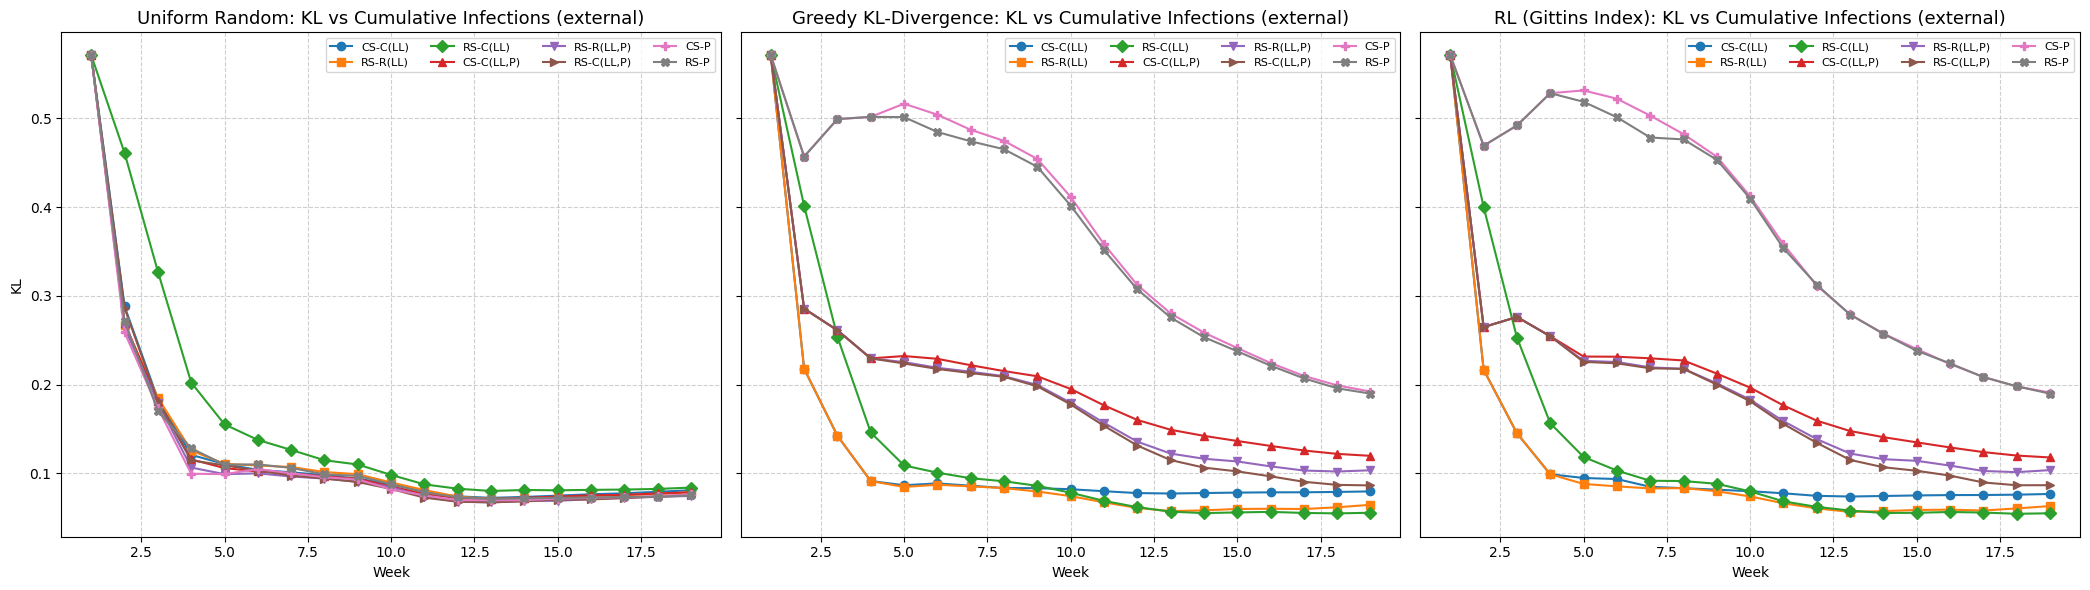

Saved: result/scenarios_1to8_vs_roll4_infections_external.png


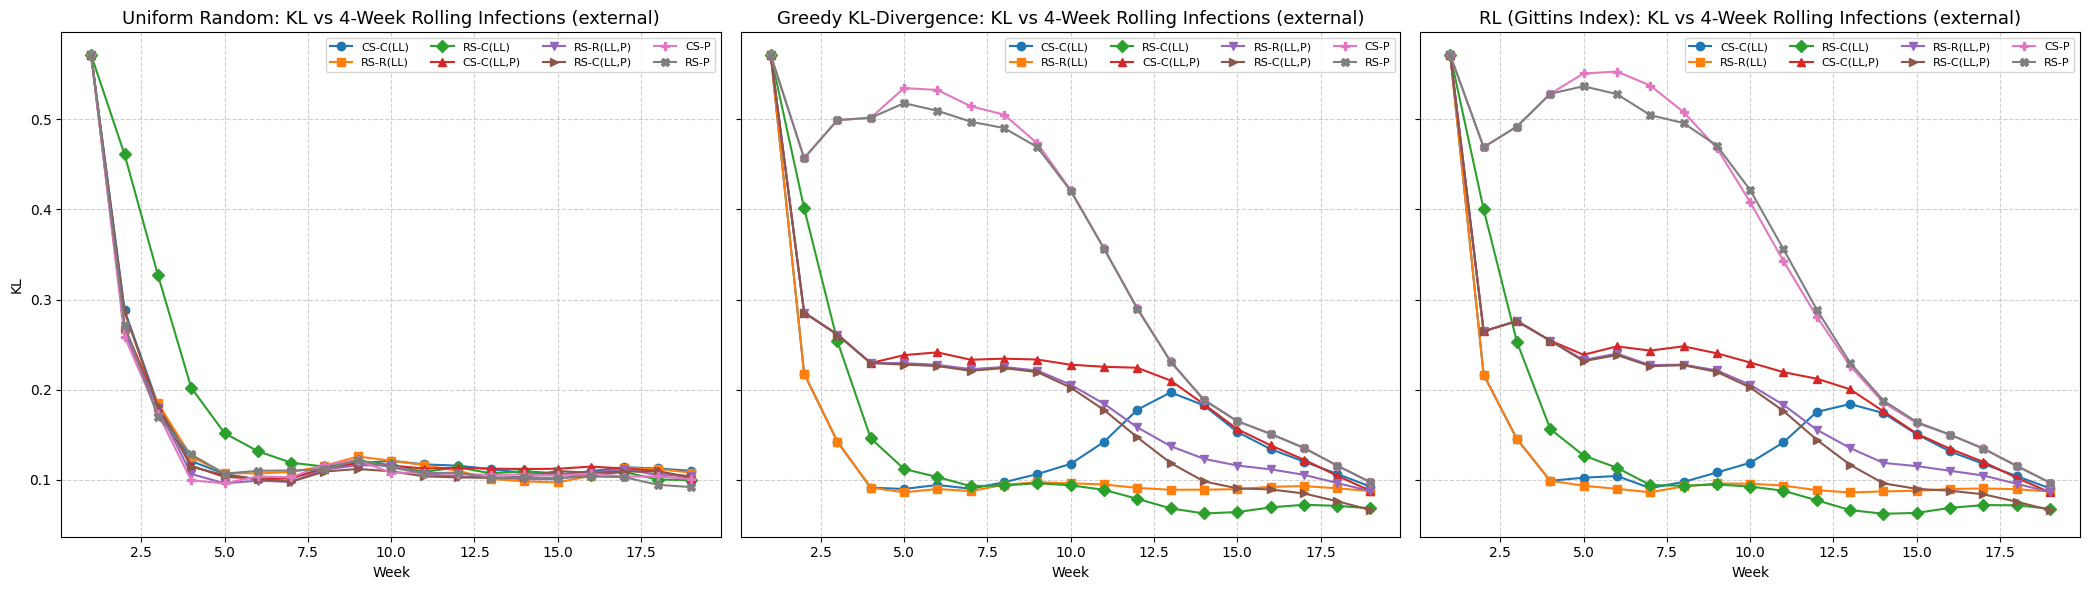

In [4]:
# ================================================
# EXTRA: Compare to external *infections* file
# ================================================
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Inputs
INF_FILE = "run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv"  # your TSV
ROLL_WIN_FOR_INFECTIONS = 4  # for rolling-window infections figure
SIMULATION_EPOCH = pd.to_datetime("2020-01-01")  # only used if we must derive dates from 'tick'

# ---- Load infections TSV
infection_df = pd.read_csv(INF_FILE, sep="\t", skiprows=[1])

infection_df = infection_df.rename(columns={'sim_pid': 'pid'})


# Ensure there's a usable date column
date_col = None
for c in ["date", "Date", "infection_date", "diagnosis_date", "onset_date"]:
    if c in infection_df.columns:
        date_col = c
        break

if date_col is None:
    # Fallback: derive from integer 'tick' if present
    if "tick" in infection_df.columns:
        infection_df["__date"] = SIMULATION_EPOCH + pd.to_timedelta(infection_df["tick"].astype(int), unit="D")
        date_col = "__date"
    else:
        raise ValueError(
            "Could not find a date-like column in the infections file. "
            "Expected one of ['date','Date','infection_date','diagnosis_date','onset_date'] "
            "or an integer 'tick' column."
        )

infection_df[date_col] = pd.to_datetime(infection_df[date_col])

# Map infections to your demographic 'group'
if "pid" not in infection_df.columns:
    raise ValueError("The infections file must contain a 'pid' column to map to groups.")

if "pid" not in pop_df.columns:
    raise ValueError("pop_df must have a 'pid' column to map infections to demographic groups.")

pid_group_map = pop_df[["pid", "group"]].dropna()
infection_df = infection_df.merge(pid_group_map, on="pid", how="left")
missing_groups = infection_df["group"].isna().sum()
if missing_groups > 0:
    print(f"Warning: {missing_groups} infection rows have unknown 'group' and will be dropped.")
infection_df = infection_df.dropna(subset=["group"])

# ---- Build weekly infections history aligned to your sampling weeks
# Reuse the same week slicing you used for linelist/sampling (based on START_DATE)
weekly_infections_history = []
cur = START_DATE
# align to the number of weeks you had for linelist; safe since eval uses min() anyway
num_weeks_ref = len(weekly_linelist_history)

for _ in range(num_weeks_ref):
    prev_mon = cur - timedelta(days=7)
    prev_sun = cur - timedelta(days=1)
    mask = (infection_df[date_col] >= prev_mon) & (infection_df[date_col] <= prev_sun)
    week_counts = infection_df.loc[mask, "group"].value_counts()
    weekly_infections_history.append(week_counts)
    cur += timedelta(weeks=1)

# ---- KL helpers against infections
from scipy.stats import entropy

def _kl(p: pd.Series, q: pd.Series) -> float:
    idx = p.index.union(q.index)
    p = p.reindex(idx, fill_value=1e-9)
    q = q.reindex(idx, fill_value=1e-9)
    return float(entropy(p, q))

def cumulative_kl_vs_infections(weekly_sample_hist, weekly_inf_hist):
    cum_s = pd.Series(dtype=float); cum_i = pd.Series(dtype=float)
    out = []
    n = min(len(weekly_sample_hist), len(weekly_inf_hist))
    for i in range(n):
        cum_s = cum_s.add(weekly_sample_hist[i], fill_value=0)
        cum_i = cum_i.add(weekly_inf_hist[i], fill_value=0)
        if cum_s.sum() == 0 or cum_i.sum() == 0:
            out.append(np.nan); continue
        out.append(_kl(cum_s / cum_s.sum(), cum_i / cum_i.sum()))
    return out

def rolling_kl_vs_infections(weekly_sample_hist, weekly_inf_hist, window_weeks=4):
    out = []
    n = min(len(weekly_sample_hist), len(weekly_inf_hist))
    for i in range(n):
        s = pd.Series(dtype=float); inf = pd.Series(dtype=float)
        start = max(0, i - window_weeks + 1)
        for j in range(start, i + 1):
            s   = s.add(weekly_sample_hist[j],   fill_value=0)
            inf = inf.add(weekly_inf_hist[j],    fill_value=0)
        if s.sum() == 0 or inf.sum() == 0:
            out.append(np.nan); continue
        out.append(_kl(s / s.sum(), inf / inf.sum()))
    return out

# ---- Make the two 3-panel figures (one per algorithm)
outdir = Path("result"); outdir.mkdir(exist_ok=True)
marker_map = {1:"o", 2:"s", 3:"D", 4:"^", 5:"v", 6:">", 7:"P", 8:"X"}
algo_list  = ["Uniform Random", "Greedy KL-Divergence", "RL (Gittins Index)"]

# Sanity: need the per-scenario weekly sample histories
if "all_weekly_hist" not in globals():
    raise RuntimeError(
        "Expected 'all_weekly_hist' (scenario_id -> {algorithm: [weekly Series]}). "
        "Make sure you stored it when running scenarios."
    )

SCEN_LABELS = {
    1: "CS-C(LL)",
    2: "RS-R(LL)",
    3: "RS-C(LL)",
    4: "CS-C(LL,P)",
    5: "RS-R(LL,P)",
    6: "RS-C(LL,P)",
    7: "CS-P",
    8: "RS-P",
}

# A) KL vs cumulative infections
figA, axesA = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
for ax, algo in zip(axesA, algo_list):
    ax.set_title(f"{algo}: KL vs Cumulative Infections (external)", fontsize=13)
    ax.set_xlabel("Week"); ax.set_ylabel("KL" if ax is axesA[0] else "")
    for scn in range(1, 9):
        if scn not in all_weekly_hist or algo not in all_weekly_hist[scn]:
            continue
        ys = cumulative_kl_vs_infections(all_weekly_hist[scn][algo], weekly_infections_history)
        if not ys:
            continue
        x = list(range(1, len(ys)+1))
        lab = SCEN_LABELS.get(scn, f"Scenario {scn}")
        ax.plot(x, ys, linestyle="-", marker=marker_map.get(scn, "o"), label=lab)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=8)
figA.tight_layout()
outA = outdir / "scenarios_1to8_vs_cum_infections_external.png"
plt.savefig(outA, dpi=150); print(f"Saved: {outA}")
plt.show()

# B) KL vs rolling-window infections
figB, axesB = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
for ax, algo in zip(axesB, algo_list):
    ax.set_title(f"{algo}: KL vs {ROLL_WIN_FOR_INFECTIONS}-Week Rolling Infections (external)", fontsize=13)
    ax.set_xlabel("Week"); ax.set_ylabel("KL" if ax is axesB[0] else "")
    for scn in range(1, 9):
        if scn not in all_weekly_hist or algo not in all_weekly_hist[scn]:
            continue
        ys = rolling_kl_vs_infections(all_weekly_hist[scn][algo],
                                      weekly_infections_history,
                                      window_weeks=ROLL_WIN_FOR_INFECTIONS)
        if not ys:
            continue
        x = list(range(1, len(ys)+1))
        lab = SCEN_LABELS.get(scn, f"Scenario {scn}")
        ax.plot(x, ys, linestyle="-", marker=marker_map.get(scn, "o"), label=lab)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=4, fontsize=8)
figB.tight_layout()
outB = outdir / f"scenarios_1to8_vs_roll{ROLL_WIN_FOR_INFECTIONS}_infections_external.png"
plt.savefig(outB, dpi=150); print(f"Saved: {outB}")
plt.show()


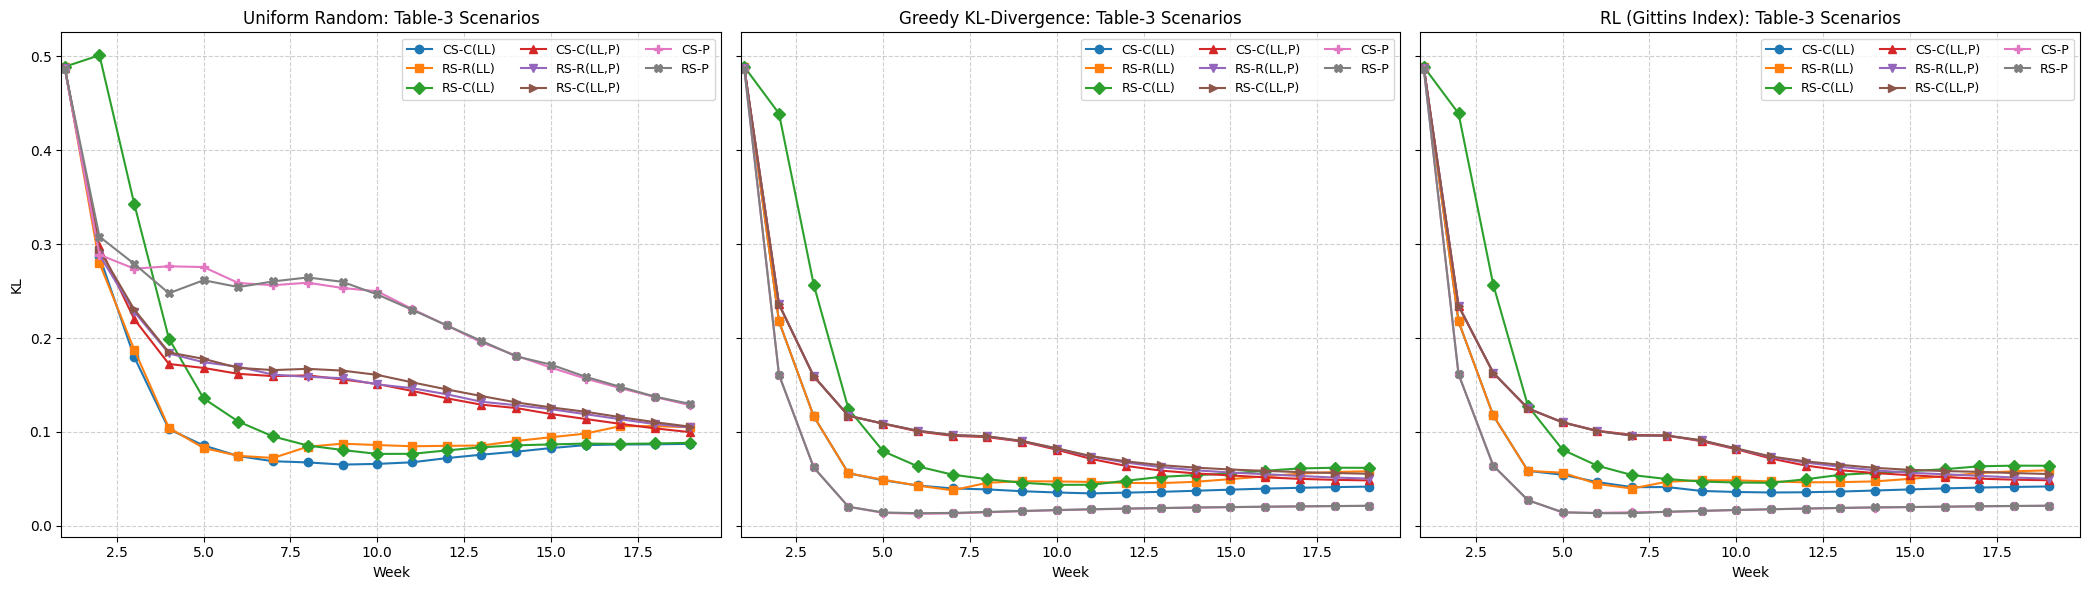

In [3]:
# ----- Plot 3 graphs with Table-3 labels -----
import matplotlib.pyplot as plt
from pathlib import Path

# Table-3 labels for scenarios 1..8
SCEN_LABELS = {
    1: "CS-C(LL)",
    2: "RS-R(LL)",
    3: "RS-C(LL)",
    4: "CS-C(LL,P)",
    5: "RS-R(LL,P)",
    6: "RS-C(LL,P)",
    7: "CS-P",
    8: "RS-P",
}

# Markers per scenario for readability
MARKERS = {1:"o", 2:"s", 3:"D", 4:"^", 5:"v", 6:">", 7:"P", 8:"X"}

# Algorithms in the order you’ve been using
ALGO_LIST = ["Uniform Random", "Greedy KL-Divergence", "RL (Gittins Index)"]

# Where to save
outdir = Path("result"); outdir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

for ax, algo in zip(axes, ALGO_LIST):
    ax.set_title(f"{algo}: Table-3 Scenarios")
    ax.set_xlabel("Week")
    ax.set_ylabel("KL" if ax is axes[0] else "")

    # Plot scenarios 1..8 with Table-3 labels
    for sid in range(1, 9):
        if algo not in scenario_series or sid not in scenario_series[algo]:
            continue
        x, y = scenario_series[algo][sid]
        lab = SCEN_LABELS.get(sid, f"Scenario {sid}")
        ax.plot(x, y, linestyle="-", marker=MARKERS.get(sid, "o"), label=lab)

    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=3, fontsize=9)
    ax.set_xlim(left=0.9)

fig.tight_layout()
plt.savefig(outdir / "scenarios_table3_labels_by_algorithm.png", dpi=150)
plt.show()
